In [1]:
!pip install datasets
!pip install optuna
!pip install scikit-multilearn
!pip install PyEvALL

import pandas as pd
import logging
from datasets import Dataset
import os
import optuna
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from transformers import set_seed
import torch
from torch.utils.data import Dataset, DataLoader
import random

# Import the drive library
from google.colab import drive
drive.mount('/content/drive/')
import sys
sys.path.append('drive/MyDrive/Colab/thesis/models')
from utils_classification import *

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
seed = 0
set_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
dir = "/content/drive/MyDrive/Colab/thesis"

In [4]:
class DataLoader:
    def __init__(self, tokenizer, device='cpu', max_length=512):
        """
        Initialize the data loader.

        Parameters:
        - tokenizer: Hugging Face tokenizer.
        - device (str): Device to load the tensors onto.
        - max_length (int): Max sequence length for padding/truncation.
        """
        self.tokenizer = tokenizer
        self.device = device
        self.max_length = max_length

    def tokenize(self, texts):
        """
        Tokenize a list of text samples.

        Parameters:
        - texts (list): List of strings.

        Return:
        - dict: Tokenized inputs as tensors on the specified device.
        """
        tokenized = self.tokenizer(
            texts,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        ).to(self.device)

        return tokenized

    def load(self, data, labels=None):
        """
        Load and return a Hugging Face Dataset object.

        Parameters:
        - data (list): List of input texts.
        - labels (list, optional): Labels corresponding to the input texts.

        Return:
        - Dataset: Hugging Face Dataset object with tokenized inputs.
        """
        tokenized = self.tokenize(data)

        if labels is not None:
            tokenized = {**tokenized, 'labels': torch.tensor(labels).to(self.device)}

        dataset_dict = {k: v.cpu() for k, v in tokenized.items()}
        hf_dataset = Dataset.from_dict(dataset_dict)

        return hf_dataset

#MAMI: testing on EXIST

In [5]:
ds_name = "MAMI"
cross_ds_name = "EXIST2024"
mami_training_data = "".join([dir, "/data/overlapping_classes/MAMI/MAMI_training.json"])
mami_val_data = "".join([dir,"/data/overlapping_classes/MAMI/MAMI_validation.json"])
exist_test_data = "".join([dir, "/data/overlapping_classes/EXIST2024/EXIST2024_test.json"])

In [6]:
mami_train_df = pd.read_json(mami_training_data,orient='index')
mami_dev_df = pd.read_json(mami_val_data,orient='index')
exist_test_df = pd.read_json(exist_test_data,orient='index')

In [7]:
#get representation for RoBERTa:
#lowercase text input for roberta
mami_train_df["roberta representation"] = mami_train_df["meme text"].str.lower() + " </s> " + mami_train_df["meme caption"].str.lower()
mami_dev_df["roberta representation"] = mami_dev_df["meme text"].str.lower() + " </s> " + mami_dev_df["meme caption"].str.lower()
exist_test_df["roberta representation"] = exist_test_df["meme text"].str.lower() + " </s> " + exist_test_df["meme caption"].str.lower()

## Binary Classification: Misogynous vs. non-misogynous

In [8]:
evaluation_type = "binary"
#division and processing of data as input to the model
X_train = mami_train_df["roberta representation"].tolist()
y_train = mami_train_df['misogynous'].tolist()
X_dev = mami_dev_df["roberta representation"].tolist()
y_dev = mami_dev_df['misogynous'].tolist()
X_test = exist_test_df["roberta representation"].tolist()
y_test = exist_test_df['sexist'].tolist()

In [ ]:
#now let's fine-tune RoBERTa for misogyny identification

In [ ]:
#load roberta model and tokenizer
model, tokenizer, device = load_model(model_name="FacebookAI/roberta-base")
data_loader = DataLoader(tokenizer, device=device)
#tokenize data and format as dataset dict for fine-tuning
train_data = data_loader.load(X_train, y_train)
dev_data = data_loader.load(X_dev, y_dev)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
###hyperparameter tuning with Optuna as seen at https://python-bloggers.com/2022/08/hyperparameter-tuning-a-transformer-with-optuna/

task = "misogyny-identification"
model_name = "roberta-base"

# Project constants
LR_MIN = 5e-6
LR_CEIL = 1e-4
WD_MIN = 1e-6
WD_CEIL = 0.01
MIN_EPOCHS = 2
MAX_EPOCHS = 10
#PER_DEVICE_EVAL_BATCH = 8
#PER_DEVICE_TRAIN_BATCH = 8
NUM_TRIALS = 3
SAVE_DIR = dir + f"/models/cross_dataset/{ds_name}/{evaluation_type}/roberta/{model_name}-{task}"
NAME_OF_MODEL = model_name
#MAX_LENGTH = 512

def objective(trial: optuna.Trial) -> float:

    batch_size = trial.suggest_categorical("batch_size", [8,16,32,64])

    training_args = TrainingArguments(
        output_dir=SAVE_DIR,
        learning_rate=trial.suggest_float('learning_rate', low=LR_MIN, high=LR_CEIL,log=True),
        weight_decay=trial.suggest_float('weight_decay', WD_MIN, WD_CEIL,log=True),
        num_train_epochs=trial.suggest_int('num_train_epochs', low = MIN_EPOCHS,high = MAX_EPOCHS),
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        report_to="none",
        save_strategy="no",
        metric_for_best_model="eval_f1"
        #disable_tqdm=True
        )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
        )

    result = trainer.train()
    return result.training_loss

In [ ]:
print('Triggering Optuna study')
study = optuna.create_study(study_name='hp-search-roberta', direction='minimize')
study.optimize(objective, n_trials=NUM_TRIALS)

# This can be used to train the final model. Passed through using kwargs into the model
print('Finding study best parameters')
best_lr = float(study.best_params['learning_rate'])
best_weight_decay = float(study.best_params['weight_decay'])
best_epoch = int(study.best_params['num_train_epochs'])
best_batch_size = int(study.best_params['batch_size'])

print('Extract best study params')
print(f'The best learning rate is: {best_lr}')
print(f'The best weight decay is: {best_weight_decay}')
print(f'The best epoch is : {best_epoch}')
print(f'The best batch size is: {best_batch_size}')


[I 2025-06-12 08:38:46,371] A new study created in memory with name: hp-search-roberta


Triggering Optuna study


Step,Training Loss


[I 2025-06-12 08:39:39,292] Trial 0 finished with value: 0.6389541110476932 and parameters: {'batch_size': 8, 'learning_rate': 5.925272036185102e-06, 'weight_decay': 3.437776296339225e-05, 'num_train_epochs': 2}. Best is trial 0 with value: 0.6389541110476932.


Step,Training Loss


[I 2025-06-12 08:40:44,726] Trial 1 finished with value: 0.4387357946027789 and parameters: {'batch_size': 64, 'learning_rate': 4.645101968932189e-05, 'weight_decay': 8.61680472624859e-06, 'num_train_epochs': 3}. Best is trial 1 with value: 0.4387357946027789.


Step,Training Loss


[I 2025-06-12 08:43:06,198] Trial 2 finished with value: 0.143887236311629 and parameters: {'batch_size': 16, 'learning_rate': 2.9442655085830332e-05, 'weight_decay': 5.92012656666037e-05, 'num_train_epochs': 6}. Best is trial 2 with value: 0.143887236311629.


Finding study best parameters
Extract best study params
The best learning rate is: 2.9442655085830332e-05
The best weight decay is: 5.92012656666037e-05
The best epoch is : 6
The best batch size is: 16


In [ ]:
task = "misogyny-identification"
model_name = "roberta-base"
SAVE_DIR = dir + f"/models/cross_dataset/{ds_name}/{evaluation_type}/roberta/{model_name}-{task}"

print('Training the model on the custom parameters')

args = TrainingArguments(
        output_dir=SAVE_DIR,
        eval_strategy="epoch",
        learning_rate=best_lr,
        per_device_train_batch_size=best_batch_size,
        per_device_eval_batch_size=best_batch_size,
        num_train_epochs=best_epoch,
        weight_decay=best_weight_decay,
        report_to="none",
        save_strategy="no",
        metric_for_best_model="eval_f1"
    )

trainer = Trainer(
        model,
        args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
    )
result = trainer.train()

Training the model on the custom parameters


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.089800,0.848485,0.848485,0.848485
2,No log,1.104524,0.827638,0.825758,0.825507
3,No log,1.201737,0.842877,0.840909,0.840680
4,No log,1.171473,0.858116,0.856061,0.855854
5,No log,1.154265,0.871297,0.871212,0.871205
6,No log,1.249070,0.858116,0.856061,0.855854


In [ ]:
trainer.evaluate()

{'eval_loss': 1.2490696907043457,
 'eval_precision': 0.8581159085661509,
 'eval_recall': 0.8560606060606061,
 'eval_f1': 0.8558537847002701,
 'eval_runtime': 0.897,
 'eval_samples_per_second': 147.158,
 'eval_steps_per_second': 10.034,
 'epoch': 6.0}

In [ ]:
model_dir = dir + f"/models/cross_dataset/{ds_name}/{evaluation_type}/roberta/{model_name}-{task}"
tokenizer.save_pretrained(model_dir+"/tokenizer")
model.save_pretrained(model_dir+"/model")

In [ ]:
# testing fine-tuned model for misogyny identification

In [9]:
#loading fine-tuned model and tokenizer
evaluation_type = "binary"
task = "misogyny-identification"
model_name = "roberta-base"
model_dir = dir + f"/models/cross_dataset/{ds_name}/{evaluation_type}/roberta/{model_name}-{task}"
misogyny_id_model = AutoModelForSequenceClassification.from_pretrained(model_dir+"/model")
misogyny_id_tokenizer = AutoTokenizer.from_pretrained(model_dir+"/tokenizer")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
misogyny_id_model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [10]:
#make predictions on test data
y_pred = exist_test_df["roberta representation"].apply(lambda x: classify_text(x, misogyny_id_model, misogyny_id_tokenizer, device))

Saved EXIST2024 test split binary evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/overlapping_classes/predictions/EXIST2024/roberta_EXIST2024_test_binary.json
Saved EXIST2024 test split to /content/drive/MyDrive/Colab/thesis/models/evaluation/overlapping_classes/predictions/EXIST2024/roberta_EXIST2024_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report for RoBERTa (Cross-Dataset):
              precision    recall  f1-score   support

  non-sexist       0.68      0.59      0.63        76
      sexist       0.64      0.72      0.68        76

    accuracy                           0.66       152
   macro avg       0.66      0.66      0.66       152
weighted avg       0.66      0.66      0.66       152

----------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------

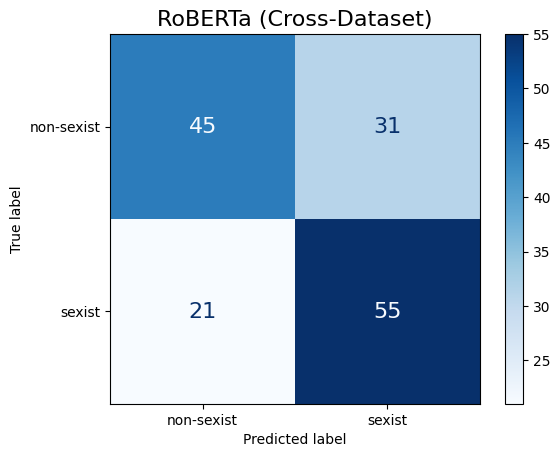

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
PyEvaLL Metrics for RoBERTa (Cross-Dataset):

2025-06-24 14:49:07,024 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM', 'ICMNorm', 'FMeasure']
2025-06-24 14:49:07,069 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-06-24 14:49:07,121 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM Normalized evaluation method
2025-06-24 14:49:07,125 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-06-24 14:49:07,179 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-06-24 14:49:07,226 - pyevall.metrics.metrics - INFO -             evaluate() - Executing fmeasure evaluation method
cargado 29
Th

In [11]:
# CROSS-DATASET EVALUATION:
gold_path_test_binary =  dir+f"/models/evaluation/overlapping_classes/golds/{cross_ds_name}/{cross_ds_name}_test_{evaluation_type}.json"
gold_test_txt = dir+f"/models/evaluation/overlapping_classes/golds/{cross_ds_name}/{cross_ds_name}_test_truth.txt"
#create file with predictions
test_pred_json,test_pred_txt = save_evaluation(exist_test_df, dir+"/models/evaluation/overlapping_classes/predictions", cross_ds_name, "test", evaluation_type, "roberta", y_pred, "sexist", [])
#get evaluation metrics
evaluate_binary_classification(gold_path_test_binary,test_pred_json,
                               y_test,y_pred,
                                ["non-sexist","sexist"],
                               gold_test_txt,test_pred_txt,
                               model_name="RoBERTa (Cross-Dataset)")

In [ ]:
#save predictions on test set
output_dir = os.path.join(dir, "models","output","cross_dataset",cross_ds_name) #creating dir for output
os.makedirs(output_dir, exist_ok=True)
output_path = f"{output_dir}/roberta_{cross_ds_name}_test_{evaluation_type}.csv"
save_predictions_csv(exist_test_df, y_pred.to_numpy(), ["sexist"], output_path)

Predictions saved to /content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/EXIST2024/roberta_EXIST2024_test_binary.csv


## Multilabel classification: Misogyny Categorization

### Hierarchical predictions after step 1 w/ensemble

In [8]:
evaluation_type = "hierarchical"
binary_label = "misogynous"
train_bin_pos = mami_train_df[mami_train_df[binary_label] == 1] #only the instances with positive class in binary level
dev_positive = mami_dev_df[mami_dev_df[binary_label] == 1]

In [ ]:
#division and processing of data as input to the model
X_train = train_bin_pos["roberta representation"].tolist()
X_dev = dev_positive["roberta representation"].tolist()

In [ ]:
#constants
MODEL_NAME = "roberta-base"

LR_MIN = 5e-6
LR_CEIL = 1e-4
WD_MIN = 1e-6
WD_CEIL = 0.01
MIN_EPOCHS = 5
MAX_EPOCHS = 10
#PER_DEVICE_EVAL_BATCH = 8
#PER_DEVICE_TRAIN_BATCH = 8
NUM_TRIALS = 5
SAVE_DIR = dir + f"/models/cross_dataset/{ds_name}/{evaluation_type}/roberta/{MODEL_NAME}"
#MAX_LENGTH = 512

def objective(trial: optuna.Trial) -> float:

    batch_size = trial.suggest_categorical("batch_size", [8,16,32,64])

    training_args = TrainingArguments(
        output_dir=f"{SAVE_DIR}-{label}",
        learning_rate=trial.suggest_float('learning_rate', low=LR_MIN, high=LR_CEIL,log=True),
        weight_decay=trial.suggest_float('weight_decay', WD_MIN, WD_CEIL,log=True),
        num_train_epochs=trial.suggest_int('num_train_epochs', low = MIN_EPOCHS,high = MAX_EPOCHS),
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        report_to="none",
        save_strategy="no",
        metric_for_best_model="eval_f1",
        disable_tqdm=True
        )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
        )

    result = trainer.train()
    return result.training_loss

In [ ]:
model, tokenizer, device = load_model(model_name="FacebookAI/roberta-base")
data_loader = DataLoader(tokenizer, device=device)


fine_grained_labels = ["stereotype","objectification","violence"] #only fine-grained labels

# Binary relevance loop
for label in fine_grained_labels:
    print(f"{'-'*100}\nRunning Optuna tuning for label: {label}\n")

    #get labels
    y_train = train_bin_pos[label].to_numpy()
    y_dev = dev_positive[label].to_numpy()

    #tokenize data and format as dataset dict for fine-tuning
    train_data = data_loader.load(X_train, y_train)
    dev_data = data_loader.load(X_dev, y_dev)

    # Run hyperparameter tuning with optuna
    study = optuna.create_study(study_name='hp-search-roberta', direction='minimize')
    study.optimize(objective, n_trials=NUM_TRIALS)

    print(f"\nBest trial for {label}: {study.best_trial.params}\n{'-'*100}")
    print(f"{'-'*100}\nTraining model with best parameters for label: {label}\n")

    # Train best model with best params
    best_params = study.best_trial.params
    training_args = TrainingArguments(
        output_dir=f"{SAVE_DIR}-{label}",
        eval_strategy="epoch",
        learning_rate=best_params['learning_rate'],
        weight_decay=best_params['weight_decay'],
        num_train_epochs=best_params['num_train_epochs'],
        per_device_train_batch_size=best_params['batch_size'],
        per_device_eval_batch_size=best_params['batch_size'],
        metric_for_best_model="eval_f1",
        save_strategy="no",
        report_to="none",
        #disable_tqdm=True,
    )

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

    final_trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
    )

    final_trainer.train()

    #save model
    output_dir=f"{SAVE_DIR}-{label}"
    tokenizer.save_pretrained(f"{output_dir}/tokenizer")
    model.save_pretrained(f"{output_dir}/model")

    print(f"\nSaved tokenizer and model for {label}\n{'-'*100}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------------------------------------------------------------------------------------------------
Running Optuna tuning for label: stereotype



[I 2025-06-15 12:22:40,837] A new study created in memory with name: hp-search-roberta
[I 2025-06-15 12:24:07,906] Trial 0 finished with value: 0.627207088470459 and parameters: {'batch_size': 64, 'learning_rate': 7.5892374146400525e-06, 'weight_decay': 1.0077372223253502e-05, 'num_train_epochs': 8}. Best is trial 0 with value: 0.627207088470459.


{'train_runtime': 86.6519, 'train_samples_per_second': 53.825, 'train_steps_per_second': 0.923, 'train_loss': 0.627207088470459, 'epoch': 8.0}


[I 2025-06-15 12:25:47,008] Trial 1 finished with value: 0.5885725411755299 and parameters: {'batch_size': 32, 'learning_rate': 9.234468066823495e-05, 'weight_decay': 2.7797221887731897e-06, 'num_train_epochs': 9}. Best is trial 1 with value: 0.5885725411755299.


{'train_runtime': 98.7201, 'train_samples_per_second': 53.15, 'train_steps_per_second': 1.732, 'train_loss': 0.5885725411755299, 'epoch': 9.0}


[I 2025-06-15 12:27:31,585] Trial 2 finished with value: 0.16243606429916244 and parameters: {'batch_size': 16, 'learning_rate': 2.9452837041842206e-05, 'weight_decay': 7.08075622375116e-05, 'num_train_epochs': 9}. Best is trial 2 with value: 0.16243606429916244.


{'train_runtime': 104.1727, 'train_samples_per_second': 50.368, 'train_steps_per_second': 3.197, 'train_loss': 0.16243606429916244, 'epoch': 9.0}


[I 2025-06-15 12:29:08,083] Trial 3 finished with value: 0.05343585544162326 and parameters: {'batch_size': 64, 'learning_rate': 2.8169090747281547e-05, 'weight_decay': 4.572621238204663e-06, 'num_train_epochs': 9}. Best is trial 3 with value: 0.05343585544162326.


{'train_runtime': 96.1212, 'train_samples_per_second': 54.587, 'train_steps_per_second': 0.936, 'train_loss': 0.05343585544162326, 'epoch': 9.0}


[I 2025-06-15 12:30:17,934] Trial 4 finished with value: 0.017647861360429642 and parameters: {'batch_size': 16, 'learning_rate': 1.494300905491188e-05, 'weight_decay': 2.5976471531448322e-06, 'num_train_epochs': 6}. Best is trial 4 with value: 0.017647861360429642.


{'train_runtime': 69.4581, 'train_samples_per_second': 50.361, 'train_steps_per_second': 3.196, 'train_loss': 0.017647861360429642, 'epoch': 6.0}

Best trial for stereotype: {'batch_size': 16, 'learning_rate': 1.494300905491188e-05, 'weight_decay': 2.5976471531448322e-06, 'num_train_epochs': 6}
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training model with best parameters for label: stereotype



config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.600182,0.356061,0.500000,0.415929
2,No log,0.606053,0.356061,0.500000,0.415929
3,No log,0.599736,0.356061,0.500000,0.415929
4,No log,0.633448,0.356061,0.500000,0.415929
5,No log,0.661784,0.625000,0.578387,0.580181
6,No log,0.694749,0.580435,0.582867,0.581472


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Saved tokenizer and model for stereotype
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Running Optuna tuning for label: objectification



[I 2025-06-15 12:33:00,841] Trial 0 finished with value: 0.5669235229492188 and parameters: {'batch_size': 64, 'learning_rate': 2.8256991763034522e-05, 'weight_decay': 0.0005638206817394283, 'num_train_epochs': 8}. Best is trial 0 with value: 0.5669235229492188.


{'train_runtime': 85.4453, 'train_samples_per_second': 54.585, 'train_steps_per_second': 0.936, 'train_loss': 0.5669235229492188, 'epoch': 8.0}


[I 2025-06-15 12:34:29,029] Trial 1 finished with value: 0.6687516664203844 and parameters: {'batch_size': 32, 'learning_rate': 9.480829408185525e-05, 'weight_decay': 0.0026674663537390618, 'num_train_epochs': 8}. Best is trial 0 with value: 0.5669235229492188.


{'train_runtime': 87.7843, 'train_samples_per_second': 53.13, 'train_steps_per_second': 1.732, 'train_loss': 0.6687516664203844, 'epoch': 8.0}
{'loss': 0.6526, 'grad_norm': 3.679978847503662, 'learning_rate': 4.577526514707668e-06, 'epoch': 6.8493150684931505}


[I 2025-06-15 12:36:34,956] Trial 2 finished with value: 0.6029503704750374 and parameters: {'batch_size': 8, 'learning_rate': 1.4465776431760165e-05, 'weight_decay': 1.6281626026010902e-06, 'num_train_epochs': 10}. Best is trial 0 with value: 0.5669235229492188.


{'train_runtime': 125.5343, 'train_samples_per_second': 46.442, 'train_steps_per_second': 5.815, 'train_loss': 0.6029503704750374, 'epoch': 10.0}


[I 2025-06-15 12:38:31,099] Trial 3 finished with value: 0.4241396104967272 and parameters: {'batch_size': 16, 'learning_rate': 7.481900471761584e-05, 'weight_decay': 2.1151231786039225e-06, 'num_train_epochs': 10}. Best is trial 3 with value: 0.4241396104967272.


{'train_runtime': 115.7522, 'train_samples_per_second': 50.366, 'train_steps_per_second': 3.196, 'train_loss': 0.4241396104967272, 'epoch': 10.0}
{'loss': 0.2582, 'grad_norm': 2.8163788318634033, 'learning_rate': 1.8306485272466836e-06, 'epoch': 6.8493150684931505}


[I 2025-06-15 12:40:11,883] Trial 4 finished with value: 0.24952194788684584 and parameters: {'batch_size': 8, 'learning_rate': 1.2577632234259568e-05, 'weight_decay': 7.098246557674474e-05, 'num_train_epochs': 8}. Best is trial 4 with value: 0.24952194788684584.


{'train_runtime': 100.3952, 'train_samples_per_second': 46.456, 'train_steps_per_second': 5.817, 'train_loss': 0.24952194788684584, 'epoch': 8.0}

Best trial for objectification: {'batch_size': 8, 'learning_rate': 1.2577632234259568e-05, 'weight_decay': 7.098246557674474e-05, 'num_train_epochs': 8}
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training model with best parameters for label: objectification



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.642819,0.325758,0.500000,0.394495
2,No log,0.695544,0.325758,0.500000,0.394495
3,No log,0.502899,0.768254,0.756320,0.761364
4,No log,0.518575,0.833333,0.791203,0.805414
5,No log,0.567893,0.806250,0.747725,0.763441
6,No log,0.759705,0.765000,0.714358,0.727047
7,0.405700,0.851863,0.765000,0.714358,0.727047
8,0.405700,0.833709,0.752174,0.734580,0.741312


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Saved tokenizer and model for objectification
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Running Optuna tuning for label: violence



[I 2025-06-15 12:43:15,839] Trial 0 finished with value: 0.511792290479617 and parameters: {'batch_size': 32, 'learning_rate': 2.8937791679763186e-05, 'weight_decay': 1.1927644885786706e-05, 'num_train_epochs': 7}. Best is trial 0 with value: 0.511792290479617.


{'train_runtime': 76.873, 'train_samples_per_second': 53.088, 'train_steps_per_second': 1.73, 'train_loss': 0.511792290479617, 'epoch': 7.0}


[I 2025-06-15 12:44:14,094] Trial 1 finished with value: 0.22967057099213473 and parameters: {'batch_size': 16, 'learning_rate': 1.5106647320360882e-05, 'weight_decay': 2.2563764286676294e-06, 'num_train_epochs': 5}. Best is trial 1 with value: 0.22967057099213473.


{'train_runtime': 57.8648, 'train_samples_per_second': 50.376, 'train_steps_per_second': 3.197, 'train_loss': 0.22967057099213473, 'epoch': 5.0}


[I 2025-06-15 12:45:53,205] Trial 2 finished with value: 0.45419659530907347 and parameters: {'batch_size': 32, 'learning_rate': 9.468663784506029e-05, 'weight_decay': 0.000850286813920277, 'num_train_epochs': 9}. Best is trial 1 with value: 0.22967057099213473.


{'train_runtime': 98.7179, 'train_samples_per_second': 53.151, 'train_steps_per_second': 1.732, 'train_loss': 0.45419659530907347, 'epoch': 9.0}


[I 2025-06-15 12:47:19,082] Trial 3 finished with value: 0.09771690964698791 and parameters: {'batch_size': 64, 'learning_rate': 1.2117666640063292e-05, 'weight_decay': 1.422149564979053e-06, 'num_train_epochs': 8}. Best is trial 3 with value: 0.09771690964698791.


{'train_runtime': 85.4779, 'train_samples_per_second': 54.564, 'train_steps_per_second': 0.936, 'train_loss': 0.09771690964698791, 'epoch': 8.0}


[I 2025-06-15 12:49:06,243] Trial 4 finished with value: 0.09072842597961425 and parameters: {'batch_size': 64, 'learning_rate': 3.288727302544355e-05, 'weight_decay': 6.844424097897058e-06, 'num_train_epochs': 10}. Best is trial 4 with value: 0.09072842597961425.


{'train_runtime': 106.7695, 'train_samples_per_second': 54.604, 'train_steps_per_second': 0.937, 'train_loss': 0.09072842597961425, 'epoch': 10.0}

Best trial for violence: {'batch_size': 64, 'learning_rate': 3.288727302544355e-05, 'weight_decay': 6.844424097897058e-06, 'num_train_epochs': 10}
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training model with best parameters for label: violence



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.627915,0.340909,0.500000,0.405405
2,No log,0.625486,0.340909,0.500000,0.405405
3,No log,0.581530,0.846154,0.523810,0.454545
4,No log,0.573764,0.682353,0.647619,0.656250
5,No log,0.615439,0.706044,0.658730,0.669514
6,No log,0.680733,0.646137,0.638095,0.641304
7,No log,0.779945,0.650794,0.650794,0.650794
8,No log,0.814098,0.642257,0.625397,0.630459
9,No log,0.870184,0.637155,0.600000,0.603842
10,No log,0.892369,0.663194,0.649206,0.654260


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Saved tokenizer and model for violence
----------------------------------------------------------------------------------------------------


In [15]:
## Evaluation: hierarchical

#load first-level binary predictions
binary_label_cross = "sexist"
binary_preds = pd.read_csv(f"/content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/{cross_ds_name}/ensemble_svm_roberta_robertaswin_{cross_ds_name}_test_binary.csv")
y_pred_binary = binary_preds[f"{binary_label_cross}_prediction"].to_numpy()

In [ ]:
cross_classes = ["stereotyping-dominance","objectification", "sexual-violence"]

#filter only misogynous/sexist instances for fine-grained classification
test_positive = exist_test_df.copy()
test_positive[f"{binary_label_cross}_prediction"] = y_pred_binary
test_positive = test_positive[test_positive[f"{binary_label_cross}_prediction"] == 1] #this only applies to those that were labelled as 1 in binary

#initialize df with predictions for binary classification which will be populated with the categories
#default all fine-grained labels to 0
pred_df = pd.DataFrame({"meme_id":exist_test_df["meme id"], f"{binary_label_cross}_prediction": y_pred_binary})
columns=[f"{label}_prediction" for label in cross_classes]#rename the columns to predictions
pred_df[columns] = 0

In [ ]:
#loading fine-tuned model and tokenizer
results_df = pd.DataFrame()
evaluation_type = "hierarchical"

MODEL_NAME = "roberta-base"
SAVE_DIR = dir + f"/models/cross_dataset/{ds_name}/{evaluation_type}/roberta/{MODEL_NAME}"

fine_grained_labels = ["stereotype","objectification","violence"]

for in_label,cross_label in zip(fine_grained_labels,cross_classes):

    model_dir=f"{SAVE_DIR}-{in_label}"
    model = AutoModelForSequenceClassification.from_pretrained(model_dir+"/model")
    tokenizer = AutoTokenizer.from_pretrained(model_dir+"/tokenizer")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Predict on test set
    y_pred = test_positive["roberta representation"].apply(lambda x: classify_text(x, model, tokenizer, device))
    results_df[cross_label] = y_pred

#add fine-grained labels to the positive instances in the predictions df to get the labels for full dataset
pred_df.loc[y_pred_binary == 1, columns] = results_df.to_numpy()

#save the results file with the final predictions
output_dir_pred = os.path.join(dir, "models","output","cross_dataset",cross_ds_name,"ensemble_first_step") #creating dir for output
os.makedirs(output_dir_pred, exist_ok=True)
output_path = f"{output_dir_pred}/roberta_{cross_ds_name}_test_{evaluation_type}.csv"
pred_df.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")

Predictions saved to /content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/EXIST2024/ensemble_first_step/roberta_EXIST2024_test_hierarchical.csv


In [13]:
#compute metrics
exist_label_names = ["sexist","stereotyping-dominance","objectification", "sexual-violence"]
prediction_cols = [f"{label}_prediction" for label in exist_label_names]
results_df = pd.read_csv("/content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/EXIST2024/ensemble_first_step/roberta_EXIST2024_test_hierarchical.csv") #load results file
y_pred = results_df[prediction_cols] #get predictions
y_pred.rename(columns={col: col.replace('_prediction', '') for col in y_pred.columns if col.endswith('_prediction')}, inplace=True) #rename columns to build pyevall file
y_test = exist_test_df[exist_label_names]

/tmp/ipython-input-13-3209448988.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_pred.rename(columns={col: col.replace('_prediction', '') for col in y_pred.columns if col.endswith('_prediction')}, inplace=True) #rename columns to build pyevall file


In [16]:
evaluation_type = "hierarchical"
gold_path_test =  dir+f"/models/evaluation/overlapping_classes/golds/{cross_ds_name}/{cross_ds_name}_test_{evaluation_type}.json"
gold_test_txt = dir+f"/models/evaluation/overlapping_classes/golds/{cross_ds_name}/{cross_ds_name}_test_truth.txt"
#create file with predictions
test_pred_json,test_pred_txt = save_evaluation(exist_test_df, dir+"/models/evaluation/overlapping_classes/predictions", cross_ds_name, "test", evaluation_type, "roberta", y_pred , binary_label_cross, exist_label_names)
#get evaluation metrics
evaluate_multilabel_classification(gold_path_test,test_pred_json,
                                y_test,y_pred.to_numpy(),
                                exist_label_names,
                                gold_test_txt,test_pred_txt,
                                hierarchy=True)

Saved EXIST2024 test split hierarchical evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/overlapping_classes/predictions/EXIST2024/roberta_EXIST2024_test_hierarchical.json
Saved EXIST2024 test split to /content/drive/MyDrive/Colab/thesis/models/evaluation/overlapping_classes/predictions/EXIST2024/roberta_EXIST2024_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report:
                        precision    recall  f1-score   support

            non-sexist       0.70      0.61      0.65        76
stereotyping-dominance       0.35      0.68      0.46        40
       objectification       0.52      0.60      0.56        43
       sexual-violence       0.19      0.25      0.22        16

             micro avg       0.48      0.59      0.53       175
             macro avg       0.44      0.53      0.47       175
          weighted avg       0.53      0.59      0.54       175
           

In [ ]:
## Hierarchical predictions with Ensemble w/BERT in 1 step

In [9]:
## Evaluation: hierarchical

#load first-level binary predictions
binary_label_cross = "sexist"
binary_preds = pd.read_csv(f"/content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/{cross_ds_name}/ensemble_bert_roberta_robertaswin_{cross_ds_name}_test_binary.csv")
y_pred_binary = binary_preds[f"{binary_label_cross}_prediction"].to_numpy()

In [ ]:
cross_classes = ["stereotyping-dominance","objectification", "sexual-violence"]

#filter only misogynous/sexist instances for fine-grained classification
test_positive = exist_test_df.copy()
test_positive[f"{binary_label_cross}_prediction"] = y_pred_binary
test_positive = test_positive[test_positive[f"{binary_label_cross}_prediction"] == 1] #this only applies to those that were labelled as 1 in binary

#initialize df with predictions for binary classification which will be populated with the categories
#default all fine-grained labels to 0
pred_df = pd.DataFrame({"meme_id":exist_test_df["meme id"], f"{binary_label_cross}_prediction": y_pred_binary})
columns=[f"{label}_prediction" for label in cross_classes]#rename the columns to predictions
pred_df[columns] = 0

In [ ]:
#loading fine-tuned model and tokenizer
results_df = pd.DataFrame()
evaluation_type = "hierarchical"

MODEL_NAME = "roberta-base"
SAVE_DIR = dir + f"/models/cross_dataset/{ds_name}/{evaluation_type}/roberta/{MODEL_NAME}"

fine_grained_labels = ["stereotype","objectification","violence"]

for in_label,cross_label in zip(fine_grained_labels,cross_classes):

    model_dir=f"{SAVE_DIR}-{in_label}"
    model = AutoModelForSequenceClassification.from_pretrained(model_dir+"/model")
    tokenizer = AutoTokenizer.from_pretrained(model_dir+"/tokenizer")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Predict on test set
    y_pred = test_positive["roberta representation"].apply(lambda x: classify_text(x, model, tokenizer, device))
    results_df[cross_label] = y_pred

#add fine-grained labels to the positive instances in the predictions df to get the labels for full dataset
pred_df.loc[y_pred_binary == 1, columns] = results_df.to_numpy()

#save the results file with the final predictions
output_dir_pred = os.path.join(dir, "models","output","cross_dataset",cross_ds_name,"ensemble_w_bert_first_step") #creating dir for output
os.makedirs(output_dir_pred, exist_ok=True)
output_path = f"{output_dir_pred}/roberta_{cross_ds_name}_test_{evaluation_type}.csv"
pred_df.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")

Predictions saved to /content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/EXIST2024/ensemble_w_bert_first_step/roberta_EXIST2024_test_hierarchical.csv


In [10]:
#compute metrics
exist_label_names = ["sexist","stereotyping-dominance","objectification", "sexual-violence"]
prediction_cols = [f"{label}_prediction" for label in exist_label_names]
results_df = pd.read_csv("/content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/EXIST2024/ensemble_w_bert_first_step/roberta_EXIST2024_test_hierarchical.csv") #load results file
y_pred = results_df[prediction_cols] #get predictions
y_pred.rename(columns={col: col.replace('_prediction', '') for col in y_pred.columns if col.endswith('_prediction')}, inplace=True) #rename columns to build pyevall file
y_test = exist_test_df[exist_label_names]

/tmp/ipython-input-10-1614961559.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_pred.rename(columns={col: col.replace('_prediction', '') for col in y_pred.columns if col.endswith('_prediction')}, inplace=True) #rename columns to build pyevall file


In [11]:
evaluation_type = "hierarchical"
gold_path_test =  dir+f"/models/evaluation/overlapping_classes/golds/{cross_ds_name}/{cross_ds_name}_test_{evaluation_type}.json"
gold_test_txt = dir+f"/models/evaluation/overlapping_classes/golds/{cross_ds_name}/{cross_ds_name}_test_truth.txt"
#create file with predictions
test_pred_json,test_pred_txt = save_evaluation(exist_test_df, dir+"/models/evaluation/overlapping_classes/predictions", cross_ds_name, "test", evaluation_type, "roberta", y_pred , binary_label_cross, exist_label_names)
#get evaluation metrics
evaluate_multilabel_classification(gold_path_test,test_pred_json,
                                y_test,y_pred.to_numpy(),
                                exist_label_names,
                                gold_test_txt,test_pred_txt,
                                hierarchy=True)

Saved EXIST2024 test split hierarchical evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/overlapping_classes/predictions/EXIST2024/roberta_EXIST2024_test_hierarchical.json
Saved EXIST2024 test split to /content/drive/MyDrive/Colab/thesis/models/evaluation/overlapping_classes/predictions/EXIST2024/roberta_EXIST2024_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report:
                        precision    recall  f1-score   support

            non-sexist       0.72      0.58      0.64        76
stereotyping-dominance       0.35      0.70      0.46        40
       objectification       0.53      0.65      0.58        43
       sexual-violence       0.25      0.31      0.28        16

             micro avg       0.49      0.60      0.54       175
             macro avg       0.46      0.56      0.49       175
          weighted avg       0.54      0.60      0.55       175
           

#EXIST: testing on MAMI

In [5]:
ds_name = "EXIST2024"
cross_ds_name = "MAMI"
exist_training_data = "".join([dir, "/data/overlapping_classes/EXIST2024/EXIST2024_training.json"])
exist_val_data = "".join([dir,"/data/overlapping_classes/EXIST2024/EXIST2024_validation.json"])
mami_test_data = "".join([dir, "/data/overlapping_classes/MAMI/MAMI_test.json"])

In [6]:
exist_train_df = pd.read_json(exist_training_data,orient='index')
exist_dev_df = pd.read_json(exist_val_data,orient='index')
mami_test_df = pd.read_json(mami_test_data,orient='index')

In [7]:
#get representation for RoBERTa:
exist_train_df["roberta representation"] = exist_train_df["meme text"].str.lower() + " </s> " + exist_train_df["meme caption"].str.lower()
exist_dev_df["roberta representation"] = exist_dev_df["meme text"].str.lower() + " </s> " + exist_dev_df["meme caption"].str.lower()
mami_test_df["roberta representation"] = mami_test_df["meme text"].str.lower() + " </s> " + mami_test_df["meme caption"].str.lower()

## Binary Classification: Sexist vs. non-sexist

In [8]:
evaluation_type = "binary"
#division and processing of data as input to the model
#lowercase text input for roberta model
X_train = exist_train_df["roberta representation"].tolist()
y_train = exist_train_df["sexist"].tolist()
X_dev = exist_dev_df["roberta representation"].tolist()
y_dev = exist_dev_df["sexist"].tolist()
X_test = mami_test_df["roberta representation"].tolist()
y_test = mami_test_df["misogynous"].tolist()

In [ ]:
#load roberta model and tokenizer
model, tokenizer, device = load_model(model_name="FacebookAI/roberta-base")
data_loader = DataLoader(tokenizer, device=device)
#tokenize data and format as dataset dict for fine-tuning
train_data = data_loader.load(X_train, y_train)
dev_data = data_loader.load(X_dev, y_dev)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
###hyperparameter tuning with Optuna as seen at https://python-bloggers.com/2022/08/hyperparameter-tuning-a-transformer-with-optuna/

task = "sexism-identification"
model_name = "roberta-base"

# Project constants
LR_MIN = 5e-6
LR_CEIL = 1e-4
WD_MIN = 1e-6
WD_CEIL = 0.01
MIN_EPOCHS = 2
MAX_EPOCHS = 10
#PER_DEVICE_EVAL_BATCH = 8
#PER_DEVICE_TRAIN_BATCH = 8
NUM_TRIALS = 3
SAVE_DIR = dir + f"/models/cross_dataset/{ds_name}/{evaluation_type}/roberta/{model_name}-{task}"
NAME_OF_MODEL = model_name
#MAX_LENGTH = 512

def objective(trial: optuna.Trial) -> float:

    batch_size = trial.suggest_categorical("batch_size", [8,16,32,64])

    training_args = TrainingArguments(
        output_dir=SAVE_DIR,
        learning_rate=trial.suggest_float('learning_rate', low=LR_MIN, high=LR_CEIL,log=True),
        weight_decay=trial.suggest_float('weight_decay', WD_MIN, WD_CEIL,log=True),
        num_train_epochs=trial.suggest_int('num_train_epochs', low = MIN_EPOCHS,high = MAX_EPOCHS),
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        report_to="none",
        save_strategy="no",
        metric_for_best_model="eval_f1"
        #disable_tqdm=True
        )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
        )

    result = trainer.train()
    return result.training_loss

In [ ]:
print('Triggering Optuna study')
study = optuna.create_study(study_name='hp-search-roberta', direction='minimize')
study.optimize(objective, n_trials=NUM_TRIALS)

# This can be used to train the final model. Passed through using kwargs into the model
print('Finding study best parameters')
best_lr = float(study.best_params['learning_rate'])
best_weight_decay = float(study.best_params['weight_decay'])
best_epoch = int(study.best_params['num_train_epochs'])
best_batch_size = int(study.best_params['batch_size'])

print('Extract best study params')
print(f'The best learning rate is: {best_lr}')
print(f'The best weight decay is: {best_weight_decay}')
print(f'The best epoch is : {best_epoch}')
print(f'The best batch size is: {best_batch_size}')


[I 2025-06-12 09:10:06,606] A new study created in memory with name: hp-search-roberta


Triggering Optuna study


Step,Training Loss
500,0.374200
1000,0.084100


[I 2025-06-12 09:14:10,055] Trial 0 finished with value: 0.1708696328910293 and parameters: {'batch_size': 8, 'learning_rate': 5.426679445766376e-05, 'weight_decay': 0.0015938400038872423, 'num_train_epochs': 9}. Best is trial 0 with value: 0.1708696328910293.


Step,Training Loss


[I 2025-06-12 09:17:59,743] Trial 1 finished with value: 0.03051054000854492 and parameters: {'batch_size': 64, 'learning_rate': 6.075202450782192e-05, 'weight_decay': 0.0028088429742173654, 'num_train_epochs': 10}. Best is trial 1 with value: 0.03051054000854492.


Step,Training Loss


[I 2025-06-12 09:21:49,356] Trial 2 finished with value: 8.734992588870227e-06 and parameters: {'batch_size': 64, 'learning_rate': 1.3544458495428059e-05, 'weight_decay': 0.0007803019822117625, 'num_train_epochs': 10}. Best is trial 2 with value: 8.734992588870227e-06.


Finding study best parameters
Extract best study params
The best learning rate is: 1.3544458495428059e-05
The best weight decay is: 0.0007803019822117625
The best epoch is : 10
The best batch size is: 64


In [ ]:
task = "sexism-identification"
model_name = "roberta-base"
SAVE_DIR = dir + f"/models/cross_dataset/{ds_name}/{evaluation_type}/roberta/{model_name}-{task}"

print('Training the model on the custom parameters')

args = TrainingArguments(
        output_dir=SAVE_DIR,
        eval_strategy="epoch",
        learning_rate=best_lr,
        per_device_train_batch_size=best_batch_size,
        per_device_eval_batch_size=best_batch_size,
        num_train_epochs=best_epoch,
        weight_decay=best_weight_decay,
        report_to="none",
        save_strategy="no",
        metric_for_best_model="eval_f1"
    )

trainer = Trainer(
        model,
        args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
    )
result = trainer.train()

Training the model on the custom parameters


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,3.839682,0.693627,0.693825,0.692841
2,No log,3.925486,0.693627,0.693825,0.692841
3,No log,4.007665,0.686976,0.686976,0.685714
4,No log,4.101617,0.702564,0.701901,0.699939
5,No log,4.131113,0.702564,0.701901,0.699939
6,No log,4.149368,0.702564,0.701901,0.699939
7,No log,4.162801,0.694717,0.694439,0.692841
8,No log,4.170794,0.686976,0.686976,0.685714
9,No log,4.179172,0.686976,0.686976,0.685714
10,No log,4.209675,0.694717,0.694439,0.692841


In [ ]:
trainer.evaluate()

{'eval_loss': 4.209674835205078,
 'eval_precision': 0.6947174447174447,
 'eval_recall': 0.694438765078716,
 'eval_f1': 0.6928414715036482,
 'eval_runtime': 0.8721,
 'eval_samples_per_second': 160.527,
 'eval_steps_per_second': 3.44,
 'epoch': 10.0}

In [ ]:
model_dir = dir + f"/models/cross_dataset/{ds_name}/{evaluation_type}/roberta/{model_name}-{task}"
tokenizer.save_pretrained(model_dir+"/tokenizer")
model.save_pretrained(model_dir+"/model")

In [ ]:
# testing fine-tuned model for sexism identification

In [9]:
#loading fine-tuned model and tokenizer
evaluation_type = "binary"
task = "sexism-identification"
model_name = "roberta-base"
model_dir = dir + f"/models/cross_dataset/{ds_name}/{evaluation_type}/roberta/{model_name}-{task}"
sexism_id_model = AutoModelForSequenceClassification.from_pretrained(model_dir+"/model")
sexism_id_tokenizer = AutoTokenizer.from_pretrained(model_dir+"/tokenizer")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sexism_id_model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [10]:
#make predictions on test data
y_pred = mami_test_df["roberta representation"].apply(lambda x: classify_text(x, sexism_id_model, sexism_id_tokenizer, device))

Saved MAMI test split binary evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/overlapping_classes/predictions/MAMI/roberta_MAMI_test_binary.json
Saved MAMI test split to /content/drive/MyDrive/Colab/thesis/models/evaluation/overlapping_classes/predictions/MAMI/roberta_MAMI_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report for RoBERTa (Cross-Dataset):
                precision    recall  f1-score   support

non-misogynous       0.69      0.67      0.68       500
    misogynous       0.66      0.68      0.67       476

      accuracy                           0.68       976
     macro avg       0.68      0.68      0.68       976
  weighted avg       0.68      0.68      0.68       976

----------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------

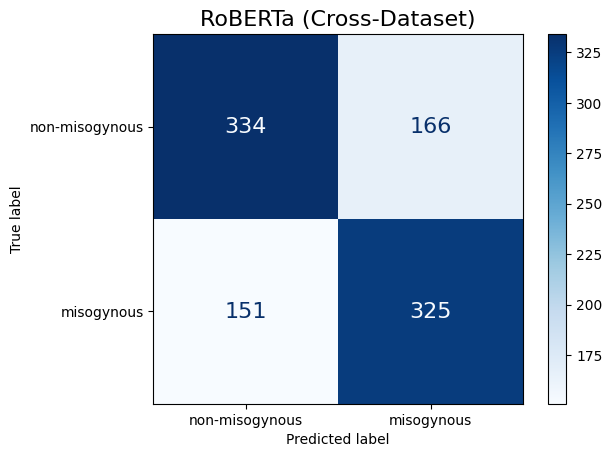

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
PyEvaLL Metrics for RoBERTa (Cross-Dataset):

2025-06-24 14:54:46,080 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM', 'ICMNorm', 'FMeasure']
2025-06-24 14:54:46,741 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-06-24 14:54:47,151 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM Normalized evaluation method
2025-06-24 14:54:47,153 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-06-24 14:54:47,571 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-06-24 14:54:47,986 - pyevall.metrics.metrics - INFO -             evaluate() - Executing fmeasure evaluation method
cargado 29
Th

In [11]:
gold_path_test_binary =  dir+f"/models/evaluation/overlapping_classes/golds/{cross_ds_name}/{cross_ds_name}_test_{evaluation_type}.json"
gold_test_txt = dir+f"/models/evaluation/overlapping_classes/golds/{cross_ds_name}/{cross_ds_name}_test_truth.txt"
#create file with predictions
test_pred_json,test_pred_txt = save_evaluation(mami_test_df, dir+"/models/evaluation/overlapping_classes/predictions", cross_ds_name, "test", evaluation_type, "roberta", y_pred, "misogynous", [])
#get evaluation metrics
evaluate_binary_classification(gold_path_test_binary,test_pred_json,
                               y_test,y_pred,
                                ["non-misogynous","misogynous"],
                               gold_test_txt,test_pred_txt,
                               model_name="RoBERTa (Cross-Dataset)")

In [ ]:
#save predictions on test set
output_dir = os.path.join(dir, "models","output","cross_dataset",cross_ds_name) #creating dir for output
os.makedirs(output_dir, exist_ok=True)
output_path = f"{output_dir}/roberta_{cross_ds_name}_test_{evaluation_type}.csv"
save_predictions_csv(mami_test_df, y_pred.to_numpy(), ["misogynous"], output_path)

Predictions saved to /content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/MAMI/roberta_MAMI_test_binary.csv


## Multilabel classification: Sexism Categorization

### Hierarchical predictions after step 1 w/ensemble

In [12]:
evaluation_type = "hierarchical"
binary_label = "sexist"
train_bin_pos = exist_train_df[exist_train_df[binary_label] == 1] #only the instances with positive class in binary level
dev_positive = exist_dev_df[exist_dev_df[binary_label] == 1]

In [ ]:
#division and processing of data as input to the model
X_train = train_bin_pos["roberta representation"].tolist()
X_dev = dev_positive["roberta representation"].tolist()

In [ ]:
#constants
MODEL_NAME = "roberta-base"

LR_MIN = 5e-6
LR_CEIL = 1e-4
WD_MIN = 1e-6
WD_CEIL = 0.01
MIN_EPOCHS = 5
MAX_EPOCHS = 10
#PER_DEVICE_EVAL_BATCH = 8
#PER_DEVICE_TRAIN_BATCH = 8
NUM_TRIALS = 5
SAVE_DIR = dir + f"/models/cross_dataset/{ds_name}/{evaluation_type}/roberta/{MODEL_NAME}"
#MAX_LENGTH = 512

def objective(trial: optuna.Trial) -> float:

    batch_size = trial.suggest_categorical("batch_size", [8,16,32,64])

    training_args = TrainingArguments(
        output_dir=f"{SAVE_DIR}-{label}",
        learning_rate=trial.suggest_float('learning_rate', low=LR_MIN, high=LR_CEIL,log=True),
        weight_decay=trial.suggest_float('weight_decay', WD_MIN, WD_CEIL,log=True),
        num_train_epochs=trial.suggest_int('num_train_epochs', low = MIN_EPOCHS,high = MAX_EPOCHS),
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        report_to="none",
        save_strategy="no",
        metric_for_best_model="eval_f1",
        disable_tqdm=True
        )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
        )

    result = trainer.train()
    return result.training_loss

In [ ]:
model, tokenizer, device = load_model(model_name="FacebookAI/roberta-base")
data_loader = DataLoader(tokenizer, device=device)

fine_grained_labels = ["stereotyping-dominance","objectification", "sexual-violence"] #only fine-grained labels

# Binary relevance loop
for label in fine_grained_labels:
    print(f"{'-'*100}\nFine-tuning model for label: {label}")

    #get labels
    y_train = train_bin_pos[label].to_numpy()
    y_dev = dev_positive[label].to_numpy()

    #tokenize data and format as dataset dict for fine-tuning
    train_data = data_loader.load(X_train, y_train)
    dev_data = data_loader.load(X_dev, y_dev)

    # Run hyperparameter tuning with optuna
    study = optuna.create_study(study_name='hp-search-roberta', direction='minimize')
    study.optimize(objective, n_trials=NUM_TRIALS)

    print(f"\nBest trial for {label}: {study.best_trial.params}\n{'-'*100}")
    print(f"{'-'*100}\nTraining model with best parameters for label: {label}\n")

    # Train best model with best params
    best_params = study.best_trial.params
    training_args = TrainingArguments(
        output_dir=f"{SAVE_DIR}-{label}",
        eval_strategy="epoch",
        learning_rate=best_params['learning_rate'],
        weight_decay=best_params['weight_decay'],
        num_train_epochs=best_params['num_train_epochs'],
        per_device_train_batch_size=best_params['batch_size'],
        per_device_eval_batch_size=best_params['batch_size'],
        metric_for_best_model="eval_f1",
        save_strategy="no",
        report_to="none",
        #disable_tqdm=True,
    )

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

    final_trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
    )

    final_trainer.train()

    #save model
    output_dir=f"{SAVE_DIR}-{label}"
    tokenizer.save_pretrained(f"{output_dir}/tokenizer")
    model.save_pretrained(f"{output_dir}/model")

    print(f"\nSaved tokenizer and model for {label}\n{'-'*100}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------------------------------------------------------------------------------------------------
Fine-tuning model for label: stereotyping-dominance


[I 2025-06-15 13:14:43,279] A new study created in memory with name: hp-search-roberta
[I 2025-06-15 13:16:08,061] Trial 0 finished with value: 0.659387613271738 and parameters: {'batch_size': 64, 'learning_rate': 1.2128574808193691e-05, 'weight_decay': 0.0005924474699101281, 'num_train_epochs': 7}. Best is trial 0 with value: 0.659387613271738.


{'train_runtime': 84.3914, 'train_samples_per_second': 54.579, 'train_steps_per_second': 0.912, 'train_loss': 0.659387613271738, 'epoch': 7.0}


[I 2025-06-15 13:18:06,279] Trial 1 finished with value: 0.4478473562412161 and parameters: {'batch_size': 16, 'learning_rate': 6.988886435147958e-05, 'weight_decay': 0.0033259042514970985, 'num_train_epochs': 9}. Best is trial 1 with value: 0.4478473562412161.


{'train_runtime': 117.8127, 'train_samples_per_second': 50.266, 'train_steps_per_second': 3.208, 'train_loss': 0.4478473562412161, 'epoch': 9.0}


[I 2025-06-15 13:19:25,213] Trial 2 finished with value: 0.07097027793763176 and parameters: {'batch_size': 16, 'learning_rate': 2.052090166615782e-05, 'weight_decay': 0.005031797937346707, 'num_train_epochs': 6}. Best is trial 2 with value: 0.07097027793763176.


{'train_runtime': 78.536, 'train_samples_per_second': 50.27, 'train_steps_per_second': 3.209, 'train_loss': 0.07097027793763176, 'epoch': 6.0}


[I 2025-06-15 13:20:49,914] Trial 3 finished with value: 0.030837563725260943 and parameters: {'batch_size': 64, 'learning_rate': 1.958554130647367e-05, 'weight_decay': 1.5003095355898066e-06, 'num_train_epochs': 7}. Best is trial 3 with value: 0.030837563725260943.


{'train_runtime': 84.3161, 'train_samples_per_second': 54.628, 'train_steps_per_second': 0.913, 'train_loss': 0.030837563725260943, 'epoch': 7.0}
{'loss': 0.0309, 'grad_norm': 0.0047607566229999065, 'learning_rate': 1.4746461713492924e-06, 'epoch': 6.024096385542169}


[I 2025-06-15 13:22:30,126] Trial 4 finished with value: 0.026600925096353954 and parameters: {'batch_size': 8, 'learning_rate': 1.0448407628706572e-05, 'weight_decay': 0.0001102889895337243, 'num_train_epochs': 7}. Best is trial 4 with value: 0.026600925096353954.


{'train_runtime': 99.8015, 'train_samples_per_second': 46.152, 'train_steps_per_second': 5.822, 'train_loss': 0.026600925096353954, 'epoch': 7.0}

Best trial for stereotyping-dominance: {'batch_size': 8, 'learning_rate': 1.0448407628706572e-05, 'weight_decay': 0.0001102889895337243, 'num_train_epochs': 7}
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training model with best parameters for label: stereotyping-dominance



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.670403,0.298507,0.500000,0.373832
2,No log,0.646386,0.812500,0.555556,0.484615
3,No log,0.697127,0.651389,0.651389,0.626866
4,No log,0.765117,0.604779,0.579167,0.571940
5,No log,0.870143,0.623518,0.615741,0.617143
6,No log,1.001783,0.622671,0.609722,0.610465
7,0.487600,1.071954,0.625238,0.621759,0.622889


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Saved tokenizer and model for stereotyping-dominance
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fine-tuning model for label: objectification


[I 2025-06-15 13:24:15,946] A new study created in memory with name: hp-search-roberta
[I 2025-06-15 13:25:48,063] Trial 0 finished with value: 0.5445678607136214 and parameters: {'batch_size': 16, 'learning_rate': 1.03574448212434e-05, 'weight_decay': 0.00024536178655088767, 'num_train_epochs': 7}. Best is trial 0 with value: 0.5445678607136214.


{'train_runtime': 91.7212, 'train_samples_per_second': 50.217, 'train_steps_per_second': 3.205, 'train_loss': 0.5445678607136214, 'epoch': 7.0}


[I 2025-06-15 13:27:59,346] Trial 1 finished with value: 0.1487185796101888 and parameters: {'batch_size': 16, 'learning_rate': 6.104578610479279e-06, 'weight_decay': 7.335581767753581e-06, 'num_train_epochs': 10}. Best is trial 1 with value: 0.1487185796101888.


{'train_runtime': 130.8775, 'train_samples_per_second': 50.276, 'train_steps_per_second': 3.209, 'train_loss': 0.1487185796101888, 'epoch': 10.0}


[I 2025-06-15 13:29:36,105] Trial 2 finished with value: 0.08801162242889404 and parameters: {'batch_size': 64, 'learning_rate': 1.781632199578573e-05, 'weight_decay': 1.6525734098772109e-06, 'num_train_epochs': 8}. Best is trial 2 with value: 0.08801162242889404.


{'train_runtime': 96.358, 'train_samples_per_second': 54.63, 'train_steps_per_second': 0.913, 'train_loss': 0.08801162242889404, 'epoch': 8.0}


[I 2025-06-15 13:30:38,383] Trial 3 finished with value: 0.1039403097970145 and parameters: {'batch_size': 32, 'learning_rate': 1.3933479665451312e-05, 'weight_decay': 2.1609822495391335e-06, 'num_train_epochs': 5}. Best is trial 2 with value: 0.08801162242889404.


{'train_runtime': 61.8701, 'train_samples_per_second': 53.176, 'train_steps_per_second': 1.697, 'train_loss': 0.1039403097970145, 'epoch': 5.0}


[I 2025-06-15 13:31:51,061] Trial 4 finished with value: 0.05870746482502331 and parameters: {'batch_size': 64, 'learning_rate': 2.4335815205178142e-05, 'weight_decay': 1.546953785884256e-06, 'num_train_epochs': 6}. Best is trial 4 with value: 0.05870746482502331.


{'train_runtime': 72.2744, 'train_samples_per_second': 54.625, 'train_steps_per_second': 0.913, 'train_loss': 0.05870746482502331, 'epoch': 6.0}

Best trial for objectification: {'batch_size': 64, 'learning_rate': 2.4335815205178142e-05, 'weight_decay': 1.546953785884256e-06, 'num_train_epochs': 6}
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training model with best parameters for label: objectification



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.675965,0.291045,0.500000,0.367925
2,No log,0.633422,0.617585,0.550824,0.506236
3,No log,0.601344,0.646480,0.629579,0.630012
4,No log,0.611009,0.643048,0.646978,0.639785
5,No log,0.671508,0.655626,0.657051,0.641711
6,No log,0.641484,0.630804,0.634158,0.625531


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Saved tokenizer and model for objectification
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fine-tuning model for label: sexual-violence


[I 2025-06-15 13:33:08,330] A new study created in memory with name: hp-search-roberta
[I 2025-06-15 13:35:19,794] Trial 0 finished with value: 0.210613523210798 and parameters: {'batch_size': 16, 'learning_rate': 5.241009479305556e-05, 'weight_decay': 0.0002722233539025186, 'num_train_epochs': 10}. Best is trial 0 with value: 0.210613523210798.


{'train_runtime': 131.0526, 'train_samples_per_second': 50.209, 'train_steps_per_second': 3.205, 'train_loss': 0.210613523210798, 'epoch': 10.0}


[I 2025-06-15 13:36:59,216] Trial 1 finished with value: 0.006581369610059829 and parameters: {'batch_size': 32, 'learning_rate': 1.881607666766272e-05, 'weight_decay': 5.360568503788042e-06, 'num_train_epochs': 8}. Best is trial 1 with value: 0.006581369610059829.


{'train_runtime': 99.0259, 'train_samples_per_second': 53.158, 'train_steps_per_second': 1.697, 'train_loss': 0.006581369610059829, 'epoch': 8.0}
{'loss': 0.0097, 'grad_norm': 0.00015444395830854774, 'learning_rate': 2.0692938902873304e-06, 'epoch': 6.024096385542169}


[I 2025-06-15 13:38:39,433] Trial 2 finished with value: 0.008327108751357294 and parameters: {'batch_size': 8, 'learning_rate': 1.4661704271426087e-05, 'weight_decay': 0.00012785158878126314, 'num_train_epochs': 7}. Best is trial 1 with value: 0.006581369610059829.


{'train_runtime': 99.813, 'train_samples_per_second': 46.146, 'train_steps_per_second': 5.821, 'train_loss': 0.008327108751357294, 'epoch': 7.0}


[I 2025-06-15 13:39:58,374] Trial 3 finished with value: 0.09482286846826947 and parameters: {'batch_size': 16, 'learning_rate': 6.976682035188574e-05, 'weight_decay': 2.8826060894422363e-05, 'num_train_epochs': 6}. Best is trial 1 with value: 0.006581369610059829.


{'train_runtime': 78.5503, 'train_samples_per_second': 50.261, 'train_steps_per_second': 3.208, 'train_loss': 0.09482286846826947, 'epoch': 6.0}


[I 2025-06-15 13:41:23,084] Trial 4 finished with value: 0.014091377134446973 and parameters: {'batch_size': 64, 'learning_rate': 3.097321888895966e-05, 'weight_decay': 9.383741259967347e-05, 'num_train_epochs': 7}. Best is trial 1 with value: 0.006581369610059829.


{'train_runtime': 84.3106, 'train_samples_per_second': 54.631, 'train_steps_per_second': 0.913, 'train_loss': 0.014091377134446973, 'epoch': 7.0}

Best trial for sexual-violence: {'batch_size': 32, 'learning_rate': 1.881607666766272e-05, 'weight_decay': 5.360568503788042e-06, 'num_train_epochs': 8}
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training model with best parameters for label: sexual-violence



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.632131,0.335821,0.500000,0.401786
2,No log,0.622200,0.335821,0.500000,0.401786
3,No log,0.597524,0.335821,0.500000,0.401786
4,No log,0.578078,0.851562,0.568182,0.532844
5,No log,0.593395,0.777322,0.602525,0.593666
6,No log,0.629817,0.793019,0.682323,0.698470
7,No log,0.621017,0.717949,0.671717,0.682641
8,No log,0.670928,0.756818,0.671212,0.684706


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Saved tokenizer and model for sexual-violence
----------------------------------------------------------------------------------------------------


In [13]:
## Evaluation: hierarchical

#load first-level binary predictions
binary_label_cross = "misogynous"
binary_preds = pd.read_csv(f"/content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/{cross_ds_name}/ensemble_svm_roberta_robertaswin_{cross_ds_name}_test_binary.csv")
y_pred_binary = binary_preds[f"{binary_label_cross}_prediction"].to_numpy()

In [ ]:
cross_classes = ["stereotype","objectification","violence"]

#filter only misogynous/sexist instances for fine-grained classification
test_positive = mami_test_df.copy()
test_positive[f"{binary_label_cross}_prediction"] = y_pred_binary
test_positive = test_positive[test_positive[f"{binary_label_cross}_prediction"] == 1] #this only applies to those that were labelled as 1 in binary

#initialize df with predictions for binary classification which will be populated with the categories
#default all fine-grained labels to 0
pred_df = pd.DataFrame({"meme_id":mami_test_df["meme id"], f"{binary_label_cross}_prediction": y_pred_binary})
columns=[f"{label}_prediction" for label in cross_classes]#rename the columns to predictions
pred_df[columns] = 0

In [ ]:
#loading fine-tuned model and tokenizer
results_df = pd.DataFrame()
evaluation_type = "hierarchical"

MODEL_NAME = "roberta-base"
SAVE_DIR = dir + f"/models/cross_dataset/{ds_name}/{evaluation_type}/roberta/{MODEL_NAME}"

fine_grained_labels = ["stereotyping-dominance","objectification", "sexual-violence"]

for in_label,cross_label in zip(fine_grained_labels,cross_classes):

    model_dir=f"{SAVE_DIR}-{in_label}"
    model = AutoModelForSequenceClassification.from_pretrained(model_dir+"/model")
    tokenizer = AutoTokenizer.from_pretrained(model_dir+"/tokenizer")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Predict on test set
    y_pred = test_positive["roberta representation"].apply(lambda x: classify_text(x, model, tokenizer, device))
    results_df[cross_label] = y_pred

#add fine-grained labels to the positive instances in the predictions df to get the labels for full dataset
pred_df.loc[y_pred_binary == 1, columns] = results_df.to_numpy()

#save the results file with the final predictions
output_dir_pred = os.path.join(dir, "models","output","cross_dataset",cross_ds_name,"ensemble_first_step") #creating dir for output
os.makedirs(output_dir_pred, exist_ok=True)
output_path = f"{output_dir_pred}/roberta_{cross_ds_name}_test_{evaluation_type}.csv"
pred_df.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")

Predictions saved to /content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/MAMI/ensemble_first_step/roberta_MAMI_test_hierarchical.csv


In [14]:
#compute metrics
mami_label_names = ["misogynous","stereotype","objectification", "violence"]
prediction_cols = [f"{label}_prediction" for label in mami_label_names]
results_df = pd.read_csv("/content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/MAMI/ensemble_first_step/roberta_MAMI_test_hierarchical.csv") #load results file
y_pred = results_df[prediction_cols] #get predictions
y_pred.rename(columns={col: col.replace('_prediction', '') for col in y_pred.columns if col.endswith('_prediction')}, inplace=True) #rename columns to build pyevall file
y_test = mami_test_df[mami_label_names]

/tmp/ipython-input-14-3193194437.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_pred.rename(columns={col: col.replace('_prediction', '') for col in y_pred.columns if col.endswith('_prediction')}, inplace=True) #rename columns to build pyevall file


In [15]:
evaluation_type = "hierarchical"
gold_path_test =  dir+f"/models/evaluation/overlapping_classes/golds/{cross_ds_name}/{cross_ds_name}_test_{evaluation_type}.json"
gold_test_txt = dir+f"/models/evaluation/overlapping_classes/golds/{cross_ds_name}/{cross_ds_name}_test_truth.txt"
#create file with predictions
test_pred_json,test_pred_txt = save_evaluation(mami_test_df, dir+"/models/evaluation/overlapping_classes/predictions", cross_ds_name, "test", evaluation_type, "roberta", y_pred , binary_label_cross, mami_label_names)
#get evaluation metrics
evaluate_multilabel_classification(gold_path_test,test_pred_json,
                                y_test,y_pred.to_numpy(),
                                mami_label_names,
                                gold_test_txt,test_pred_txt,
                                hierarchy=True)

Saved MAMI test split hierarchical evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/overlapping_classes/predictions/MAMI/roberta_MAMI_test_hierarchical.json
Saved MAMI test split to /content/drive/MyDrive/Colab/thesis/models/evaluation/overlapping_classes/predictions/MAMI/roberta_MAMI_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report:
                 precision    recall  f1-score   support

 non-misogynous       0.73      0.61      0.67       500
     stereotype       0.57      0.50      0.54       350
objectification       0.50      0.56      0.53       348
       violence       0.25      0.15      0.19       153

      micro avg       0.58      0.52      0.55      1351
      macro avg       0.52      0.46      0.48      1351
   weighted avg       0.58      0.52      0.54      1351
    samples avg       0.61      0.55      0.56      1351

---------------------------------------

In [ ]:
## Hierarchical predictions with Ensemble w/BERT in 1 step

In [16]:
## Evaluation: hierarchical

#load first-level binary predictions
binary_label_cross = "misogynous"
binary_preds = pd.read_csv(f"/content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/{cross_ds_name}/ensemble_bert_roberta_robertaswin_{cross_ds_name}_test_binary.csv")
y_pred_binary = binary_preds[f"{binary_label_cross}_prediction"].to_numpy()

In [ ]:
cross_classes = ["stereotype","objectification","violence"]

#filter only misogynous/sexist instances for fine-grained classification
test_positive = mami_test_df.copy()
test_positive[f"{binary_label_cross}_prediction"] = y_pred_binary
test_positive = test_positive[test_positive[f"{binary_label_cross}_prediction"] == 1] #this only applies to those that were labelled as 1 in binary

#initialize df with predictions for binary classification which will be populated with the categories
#default all fine-grained labels to 0
pred_df = pd.DataFrame({"meme_id":mami_test_df["meme id"], f"{binary_label_cross}_prediction": y_pred_binary})
columns=[f"{label}_prediction" for label in cross_classes]#rename the columns to predictions
pred_df[columns] = 0

In [ ]:
#loading fine-tuned model and tokenizer
results_df = pd.DataFrame()
evaluation_type = "hierarchical"

MODEL_NAME = "roberta-base"
SAVE_DIR = dir + f"/models/cross_dataset/{ds_name}/{evaluation_type}/roberta/{MODEL_NAME}"

fine_grained_labels = ["stereotyping-dominance","objectification", "sexual-violence"]

for in_label,cross_label in zip(fine_grained_labels,cross_classes):

    model_dir=f"{SAVE_DIR}-{in_label}"
    model = AutoModelForSequenceClassification.from_pretrained(model_dir+"/model")
    tokenizer = AutoTokenizer.from_pretrained(model_dir+"/tokenizer")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Predict on test set
    y_pred = test_positive["roberta representation"].apply(lambda x: classify_text(x, model, tokenizer, device))
    results_df[cross_label] = y_pred

#add fine-grained labels to the positive instances in the predictions df to get the labels for full dataset
pred_df.loc[y_pred_binary == 1, columns] = results_df.to_numpy()

#save the results file with the final predictions
output_dir_pred = os.path.join(dir, "models","output","cross_dataset",cross_ds_name,"ensemble_w_bert_first_step") #creating dir for output
os.makedirs(output_dir_pred, exist_ok=True)
output_path = f"{output_dir_pred}/roberta_{cross_ds_name}_test_{evaluation_type}.csv"
pred_df.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")

Predictions saved to /content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/MAMI/ensemble_w_bert_first_step/roberta_MAMI_test_hierarchical.csv


In [17]:
#compute metrics
mami_label_names = ["misogynous","stereotype","objectification", "violence"]
prediction_cols = [f"{label}_prediction" for label in mami_label_names]
results_df = pd.read_csv("/content/drive/MyDrive/Colab/thesis/models/output/cross_dataset/MAMI/ensemble_w_bert_first_step/roberta_MAMI_test_hierarchical.csv") #load results file
y_pred = results_df[prediction_cols] #get predictions
y_pred.rename(columns={col: col.replace('_prediction', '') for col in y_pred.columns if col.endswith('_prediction')}, inplace=True) #rename columns to build pyevall file
y_test = mami_test_df[mami_label_names]

/tmp/ipython-input-17-2121023199.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_pred.rename(columns={col: col.replace('_prediction', '') for col in y_pred.columns if col.endswith('_prediction')}, inplace=True) #rename columns to build pyevall file


In [18]:
evaluation_type = "hierarchical"
gold_path_test =  dir+f"/models/evaluation/overlapping_classes/golds/{cross_ds_name}/{cross_ds_name}_test_{evaluation_type}.json"
gold_test_txt = dir+f"/models/evaluation/overlapping_classes/golds/{cross_ds_name}/{cross_ds_name}_test_truth.txt"
#create file with predictions
test_pred_json,test_pred_txt = save_evaluation(mami_test_df, dir+"/models/evaluation/overlapping_classes/predictions", cross_ds_name, "test", evaluation_type, "roberta", y_pred , binary_label_cross, mami_label_names)
#get evaluation metrics
evaluate_multilabel_classification(gold_path_test,test_pred_json,
                                y_test,y_pred.to_numpy(),
                                mami_label_names,
                                gold_test_txt,test_pred_txt,
                                hierarchy=True)

Saved MAMI test split hierarchical evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/overlapping_classes/predictions/MAMI/roberta_MAMI_test_hierarchical.json
Saved MAMI test split to /content/drive/MyDrive/Colab/thesis/models/evaluation/overlapping_classes/predictions/MAMI/roberta_MAMI_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report:
                 precision    recall  f1-score   support

 non-misogynous       0.75      0.63      0.68       500
     stereotype       0.57      0.51      0.54       350
objectification       0.52      0.58      0.55       348
       violence       0.27      0.16      0.20       153

      micro avg       0.59      0.53      0.56      1351
      macro avg       0.53      0.47      0.49      1351
   weighted avg       0.59      0.53      0.56      1351
    samples avg       0.63      0.57      0.58      1351

---------------------------------------